In [1]:
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import torch
from model import PhiNN
from dataset import LandscapeSimulationDataset
from helpers import jump_function

## Examine training and validation datasets

In [2]:
datdir_train = "data/model_training_data"
datdir_valid = "data/model_validation_data"
nsims_train = 10
nsims_valid = 10

In [3]:
train_dataset = LandscapeSimulationDataset(
    datdir_train, nsims_train, 2, 
    transform='tensor', 
    target_transform='tensor'
)

validation_dataset = LandscapeSimulationDataset(
    datdir_valid, nsims_valid, 2, 
    transform='tensor', 
    target_transform='tensor'
)

We can preview an individual training datum, which consists of a distribution of cells $X_0\in\mathbb{R}^{n\times d}$ at time $t_0$, and a subsequent distribution of cells $X_1\in\mathbb{R}^{n\times d}$ at time $t_1$, along with parameters $\vec{p}\in\mathbb{R}^{n_{p}}$, where $n$ is the number of cells, $d$ the dimension of the cells, and $n_p$ the number of parameters that parameterize the signal function $f_{sig}(t,\cdot)$.


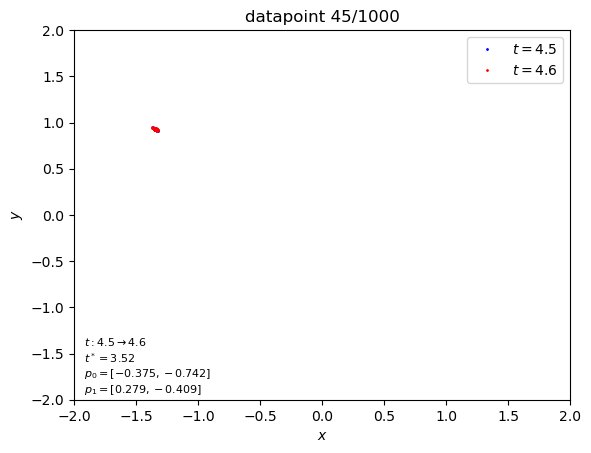

In [23]:
idx = 45
r = 2
train_dataset.preview(idx, xlims=[-r,r], ylims=[-r,r]);

We can view an animation of a full simulation, which consists of many consecutive time point pairs

In [ ]:
simidx = 9
r = 2
ani = train_dataset.animate(
    simidx, xlims=[-r, r], ylims=[-r,r], 
    show=False
)

In [ ]:
HTML(ani)

## Examine models

In [ ]:
# model_fpath = "models/model1/model3114540_20231018_191319_49"
# model_fpath = "models/model2/model3113898_20231018_190742_49"
# model_fpath = "models/model3/model3113798_20231018_224609_49"
model_fpath = "models/model4/model3207147_20231019_184546_9"

In [ ]:
NCELLS = 100
SIGMA = 1e-1

f_signal = lambda t, p: jump_function(t, p[...,0], p[...,1:3], p[...,3:])

model = PhiNN(
    ndim=2, nsig=2, f_signal=f_signal,
    ncells=NCELLS, 
    sigma=SIGMA,
)

model.load_state_dict(torch.load(model_fpath, map_location=torch.device('cpu')))
model.eval()

In [ ]:
print(list(model.parameters())[-2])

In [ ]:
for mparams in model.parameters():
    print(mparams)


## Plot of the force field

In [ ]:
# State space
r = 4
x = np.linspace(-r, r, 20)
y = np.linspace(-r, r, 20)
xs, ys = np.meshgrid(x, y)
z = np.array([xs.flatten(), ys.flatten()]).T
z = torch.tensor(z, dtype=torch.float32, requires_grad=True)

# Signal function
tcrit = 5
p0 = [0, 0]
p1 = [1, 1]
signal_params = np.array([tcrit, *p0, *p1])
signal_params = torch.tensor(signal_params, dtype=torch.float32)

t = 0  # evaluation time
f = model.f(t, z, signal_params)
phi = model.phi(z).detach()
f_arr = f.detach().numpy()
u, v = f_arr.T
norms = np.sqrt(u**2 + v**2)

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.set_title(f"$f(x,y)$")
sc = ax.quiver(xs, ys, u/norms, v/norms, norms, cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_title("$\|f\|$", size=10)
cbar.ax.tick_params(labelsize=8)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.set_title(f"$\phi(x,y)$")
ax.plot_surface(xs, ys, phi.reshape(xs.shape), cmap='coolwarm')
ax.view_init(20, 45)

In [ ]:
ttensor = torch.tensor([0, 10], dtype=torch.float32, requires_grad=True)
y0 = torch.rand([100, 2], dtype=torch.float32, requires_grad=True).flatten()
ptensor = torch.tensor([5, 0, 0, 1, 1], dtype=torch.float32, requires_grad=True)
xinput = torch.concatenate([ttensor, y0, ptensor])
z, z_hist = model.simulate_forward(xinput, dt=1e-3, history=True)

In [ ]:
# State space
r = 4
x = np.linspace(-r, r, 20)
y = np.linspace(-r, r, 20)
xs, ys = np.meshgrid(x, y)
z = np.array([xs.flatten(), ys.flatten()]).T
z = torch.tensor(z, dtype=torch.float32, requires_grad=True)

# Signal function
p_arr = ptensor.detach().numpy()
tcrit = p_arr[0]
p0 = p_arr[1:3]
p1 = p_arr[3:5]
signal_params = np.array([tcrit, *p0, *p1])
signal_params = torch.tensor(signal_params, dtype=torch.float32)


tvals = np.linspace(0, 10, len(z_hist))
for i, t in enumerate(tvals):
    if i % 100 != 0:
        continue
    f = model.f(t, z, signal_params)
    phi = model.phi(z).detach()
    f_arr = f.detach().numpy()
    u, v = f_arr.T
    norms = np.sqrt(u**2 + v**2)

    fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
    ax.set_xlabel(f"$x$")
    ax.set_ylabel(f"$y$")
    ax.set_title(f"$f(x,y), t={t:.4f}$")
    sc = ax.quiver(xs, ys, u/norms, v/norms, norms, cmap='jet')
    cbar = plt.colorbar(sc)
    cbar.ax.set_title("$\|f\|$", size=10)
    cbar.ax.tick_params(labelsize=8)
    outdir = "out/snaps"

    ax.scatter(z_hist[i][:,0], z_hist[i][:,1], s=1)

    plt.savefig(f"{outdir}/frame{i}.png")
    plt.close()

In [ ]:
for idx in range(40):
    ztraj = np.array([zi[idx] for zi in z_hist]).T
    plt.plot(ztraj[0,0], ztraj[1,0], 'r.')
    plt.plot(ztraj[0,0:ztraj.shape[1]//2], ztraj[1,0:ztraj.shape[1]//2], 'k')
    plt.plot(ztraj[0,ztraj.shape[1]//2:], ztraj[1,ztraj.shape[1]//2:], 'b')

In [ ]:
list(model.parameters())[6]

In [ ]:
from animator import SimulationAnimator

simdir = "data/model_training_data/sim0"
ani = SimulationAnimator(
    ts=np.load(f"{simdir}/ts.npy"),
    xys=np.load(f"{simdir}/xs.npy")
)

ani.animate('delme');